<a href="https://colab.research.google.com/github/cauansousa/cv2pose/blob/main/%20height_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python           
!git clone https://github.com/cauansousa/cv2pose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'cv2pose'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [3]:
!mkdir image

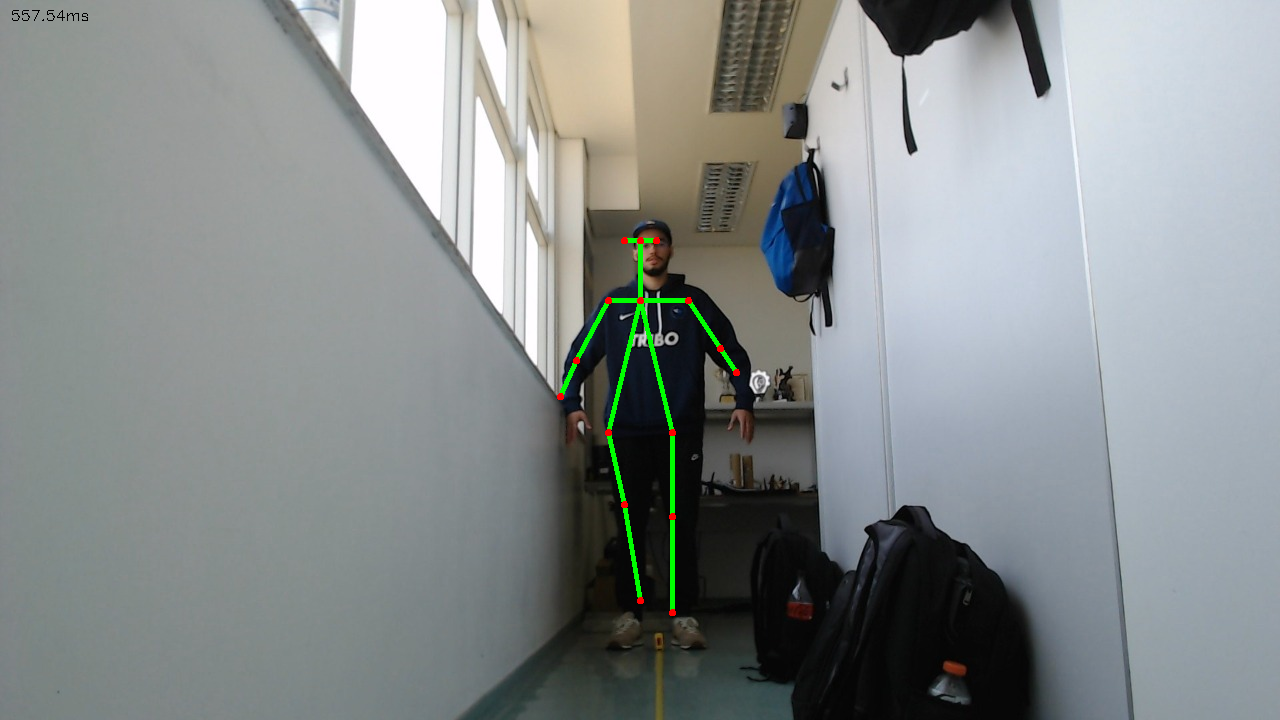

In [8]:
import cv2
import argparse
import json
from google.colab.patches import cv2_imshow

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

inWidth = 640
inHeight = 480

net = cv2.dnn.readNetFromTensorflow("/content/cv2pose/graph_opt.pb")

cap = cv2.imread('/content/image/img4.jpg')

while cv2.waitKey(1) < 0:
    frame = cap

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > 0.2 else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))


    cv2_imshow(frame) 
    break

with open("/content/points.json", "w") as f:
    json.dump(points,f)


In [16]:

null = 'null'

with open('/content/points.json', 'r') as f:
  point = json.load(f)

i = 0
for pontos in point:
    if pontos == 'null':
        continue
    elif i == 0:
      nariz = pontos[1]
    elif i == 10 and pontos:
      esq_calc = pontos[1]
      dif = esq_calc - nariz
    elif i == 13 and pontos:
      dir_calc = pontos[1]
      diff = dir_calc - nariz
    i += 1
if dif > diff:
  hpx = dif
else:
  hpx = diff

print(hpx)




372


In [18]:
dist = 4

hr = ((dist * hpx * 1.85) / 1488) 

print(hr)


1.85
